In [66]:
import pandas as pd
import numpy as np
import glob
import networkx as nx
import os

def load_forex_files_by_day(folder_pattern="./Data/forex_intraday_*.csv"):
    files = sorted(glob.glob(folder_pattern))
    day_data = {}

    for file in files:
        df = pd.read_csv(file, parse_dates=["timestamp"])
        if df.empty:
            continue
        date = pd.to_datetime(df["timestamp"].iloc[0]).date()
        day_data[date] = df

    return day_data

# Load all daily CSVs grouped by date
all_days_data = load_forex_files_by_day()


In [67]:
def build_graphs(df):
    """
    Converts a DataFrame of forex data into a dictionary of graphs by timestamp,
    using -log(rate) as edge weights.
    """
    df = df[["timestamp", "pair", "close"]]
    df_pivot = df.pivot(index="timestamp", columns="pair", values="close")
    df_log = -np.log(df_pivot)

    graphs = {}
    for timestamp, row in df_log.iterrows():
        G = nx.DiGraph()
        for pair, weight in row.items():
            if pd.notna(weight):
                from_currency = pair[:3]
                to_currency = pair[3:]
                G.add_edge(from_currency, to_currency, weight=weight)
        graphs[timestamp] = G

    return graphs


In [73]:
def normalize_cycle(cycle):
    cycle = cycle[:-1]  # remove duplicate closing node
    min_idx = min(range(len(cycle)), key=lambda i: cycle[i])
    normalized = cycle[min_idx:] + cycle[:min_idx]
    return tuple(normalized)

def find_all_negative_cycles(graph):
    all_cycles = set()
    cycles_info = []

    for source in graph.nodes:
        nodes = list(graph.nodes())
        distance = {node: float('inf') for node in nodes}
        predecessor = {node: None for node in nodes}
        distance[source] = 0

        # Bellman-Ford relaxation
        for _ in range(len(nodes) - 1):
            for u, v, data in graph.edges(data=True):
                weight = data["weight"]
                if distance[u] + weight < distance[v]:
                    distance[v] = distance[u] + weight
                    predecessor[v] = u

        # Check for negative cycle
        for u, v, data in graph.edges(data=True):
            weight = data["weight"]
            if distance[u] + weight < distance[v]:
                # Trace the cycle
                curr = v
                for _ in range(len(nodes)):
                    curr = predecessor.get(curr)
                    if curr is None:
                        break
                if curr is None:
                    continue

                cycle = []
                visited = set()
                start = curr
                while True:
                    if curr is None or curr in visited:
                        break
                    visited.add(curr)
                    cycle.append(curr)
                    curr = predecessor.get(curr)
                    if curr == start and len(cycle) > 1:
                        cycle.append(curr)
                        break

                if len(cycle) > 1 and curr == start:
                    cycle = cycle[::-1]
                    norm = normalize_cycle(cycle)
                    if norm not in all_cycles:
                        all_cycles.add(norm)
                        profit_log = sum(graph[u][v]["weight"] for u, v in zip(cycle, cycle[1:]))
                        profit = np.exp(-profit_log)
                        cycles_info.append({
                            "cycle": " → ".join(cycle),
                            "log_sum": profit_log,
                            "profit_multiplier": profit
                        })

    return cycles_info


In [69]:
# Create output folder if not already present
output_folder = "daywise_arbitrage_outputs"
os.makedirs(output_folder, exist_ok=True)

for date, df in all_days_data.items():
    print(f"Processing {date}...")

    # Step 1: Build graphs for the day
    graphs_by_time = build_graphs(df)

    # Step 2: Detect arbitrage cycles for each timestamp
    day_results = []
    for timestamp, G in graphs_by_time.items():
        cycles = find_all_negative_cycles(G)
        for cycle in cycles:
            cycle["timestamp"] = timestamp
            cycle["date"] = date
            day_results.append(cycle)

    # Step 3: Save the results for the day
    df_day = pd.DataFrame(day_results)
    out_file = os.path.join(output_folder, f"arbitrage_{date}.csv")
    df_day.to_csv(out_file, index=False)
    print(f"{len(df_day)} arbitrage cycles saved to {out_file}")


Processing 2025-01-01...
93 arbitrage cycles saved to daywise_arbitrage_outputs\arbitrage_2025-01-01.csv
Processing 2025-01-02...
1064 arbitrage cycles saved to daywise_arbitrage_outputs\arbitrage_2025-01-02.csv
Processing 2025-01-03...
366 arbitrage cycles saved to daywise_arbitrage_outputs\arbitrage_2025-01-03.csv


In [70]:
# Folder where daywise CSVs are saved
input_folder = "daywise_arbitrage_outputs"
summary_data = []

# Process each file in the output folder
for file in sorted(glob.glob(os.path.join(input_folder, "arbitrage_*.csv"))):
    df = pd.read_csv(file, parse_dates=["timestamp"])
    if df.empty:
        continue

    date = df["date"].iloc[0]
    num_cycles = len(df)
    avg_profit = df["profit_multiplier"].mean()
    max_profit = df["profit_multiplier"].max()

    summary_data.append({
        "date": date,
        "num_cycles": num_cycles,
        "avg_cycle_profit": avg_profit,
        "max_cycle_profit": max_profit
    })

# Create and save summary DataFrame
df_summary = pd.DataFrame(summary_data)
df_summary.sort_values("date", inplace=True)
df_summary.to_csv("daily_arbitrage_summary.csv", index=False)

# Show the top 5 days
print("\n📈 Daily Arbitrage Summary:")
print(df_summary.head())



📈 Daily Arbitrage Summary:
         date  num_cycles  avg_cycle_profit  max_cycle_profit
0  2025-01-01          93          1.000513          1.003686
1  2025-01-02        1064          1.000060          1.002744
2  2025-01-03         366          1.000035          1.000291


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Ensure timestamp is datetime
df_arbs["timestamp"] = pd.to_datetime(df_arbs["timestamp"])

# === Step 1: Get the best cycle across all days ===
best_row = df_arbs.loc[df_arbs["profit_multiplier"].idxmax()]
cycle_str = best_row["cycle"]
profit = best_row["profit_multiplier"]
timestamp = best_row["timestamp"]
date = timestamp.date()

# === Step 2: Parse cycle ===
cycle_nodes = cycle_str.split(" → ")
cycle_edges = list(zip(cycle_nodes, cycle_nodes[1:]))

# === Step 3: Build the graph of the cycle ===
G_base = graphs_by_time[timestamp]  # Get full graph at that time
G_cycle = nx.DiGraph()
for u, v in cycle_edges:
    weight = G_base[u][v]["weight"]
    G_cycle.add_edge(u, v, weight=weight)

# === Step 4: Visualize ===
pos = nx.circular_layout(G_cycle)
edge_labels = nx.get_edge_attributes(G_cycle, "weight")
formatted_edge_labels = {edge: f"{weight:.4f}" for edge, weight in edge_labels.items()}

plt.figure(figsize=(8, 8))
nx.draw(G_cycle, pos, with_labels=True, node_size=2000, node_color="#FFD580",
        font_size=10, font_weight='bold', arrows=True, arrowsize=20)

nx.draw_networkx_edge_labels(G_cycle, pos, edge_labels=formatted_edge_labels, font_size=8)

plt.title(f"Best Arbitrage Cycle\nDate: {date} | Profit: {profit:.4f}", size=14)
plt.axis('off')
plt.tight_layout()
plt.savefig("best_overall_arbitrage_cycle.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Best cycle on {date} with profit {profit:.6f}")
print(f"Cycle: {cycle_str}")


KeyError: Timestamp('2025-01-01 21:53:00')

C:\Users\avixa\AppData\Local\Temp\ipykernel_12468\2648371813.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


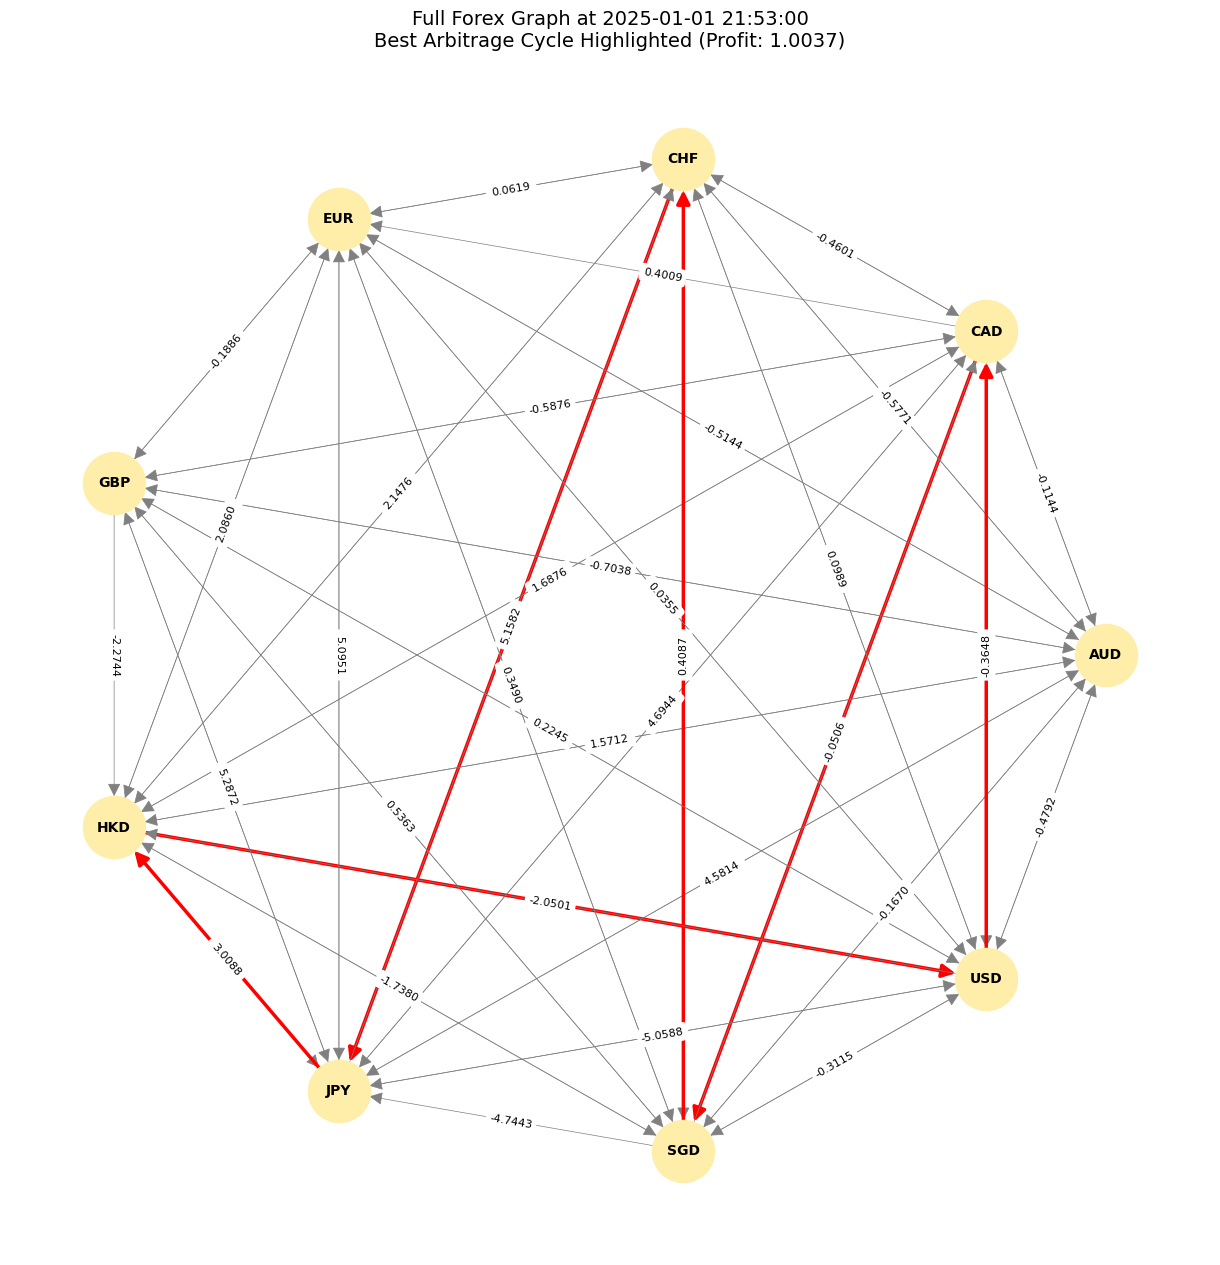

Visualized full graph at 2025-01-01 21:53:00 with best cycle highlighted.


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Find the most profitable cycle
best_row = df_arbs.loc[df_arbs["profit_multiplier"].idxmax()]
best_cycle_str = best_row["cycle"]
best_profit = best_row["profit_multiplier"]
best_timestamp = best_row["timestamp"]

# Step 2: Get the graph at that timestamp
G_full = graphs_by_time[best_timestamp]

# Step 3: Parse the best cycle
cycle_nodes = best_cycle_str.split(" → ")
cycle_edges = list(zip(cycle_nodes, cycle_nodes[1:]))

# Step 4: Prepare colors
edge_colors = []
edge_widths = []
for u, v in G_full.edges():
    if (u, v) in cycle_edges:
        edge_colors.append("red")          # Highlight cycle edges
        edge_widths.append(2.5)
    else:
        edge_colors.append("gray")         # Faint other edges
        edge_widths.append(0.5)

# Step 5: Draw the full graph
pos = nx.circular_layout(G_full)
edge_labels = nx.get_edge_attributes(G_full, "weight")
formatted_labels = {edge: f"{w:.4f}" for edge, w in edge_labels.items()}

plt.figure(figsize=(12, 12))
nx.draw(G_full, pos,
        with_labels=True,
        node_size=2000,
        node_color="#FFEEAA",
        font_size=10,
        font_weight='bold',
        edge_color=edge_colors,
        width=edge_widths,
        arrows=True,
        arrowsize=20)

nx.draw_networkx_edge_labels(G_full, pos, edge_labels=formatted_labels, font_size=8)

plt.title(f"Full Forex Graph at {best_timestamp}\nBest Arbitrage Cycle Highlighted (Profit: {best_profit:.4f})", size=14)
plt.axis('off')
plt.tight_layout()
plt.savefig("full_graph_with_best_cycle.png", dpi=300)
plt.show()

print(f"Visualized full graph at {best_timestamp} with best cycle highlighted.")